## Importar Bibliotecas

In [1]:
import os
import glob
import random
import shutil
import gc
import yaml
from pathlib import Path

import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from ultralytics import YOLO

print("✓ Bibliotecas importadas com sucesso!")
print(f"✓ GPU disponível: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  - Dispositivo: {torch.cuda.get_device_name(0)}")

✓ Bibliotecas importadas com sucesso!
✓ GPU disponível: True
  - Dispositivo: NVIDIA GeForce RTX 3060


In [2]:
# Contar imagens e labels
def count_files(image_dir, label_dir):
    images = len([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
    labels = len([f for f in os.listdir(label_dir) if f.endswith('.txt')])
    return images, labels

print("=" * 60)
print("📊 ESTATÍSTICAS DO DATASET")
print("=" * 60)

train_img_dir = "axe_dataset/train/images"
train_label_dir = train_img_dir.replace('/images', '/labels')
val_img_dir = "axe_dataset/valid/images"
val_label_dir = val_img_dir.replace('/images', '/labels')

train_imgs, train_lbls = count_files(train_img_dir, train_label_dir)
val_imgs, val_lbls = count_files(val_img_dir, val_label_dir)

print(f"\n📁 Treino:")
print(f"   Imagens: {train_imgs}")
print(f"   Labels:  {train_lbls}")

📊 ESTATÍSTICAS DO DATASET

📁 Treino:
   Imagens: 267
   Labels:  267


🖼️  Visualizando amostras do dataset com anotações reais...


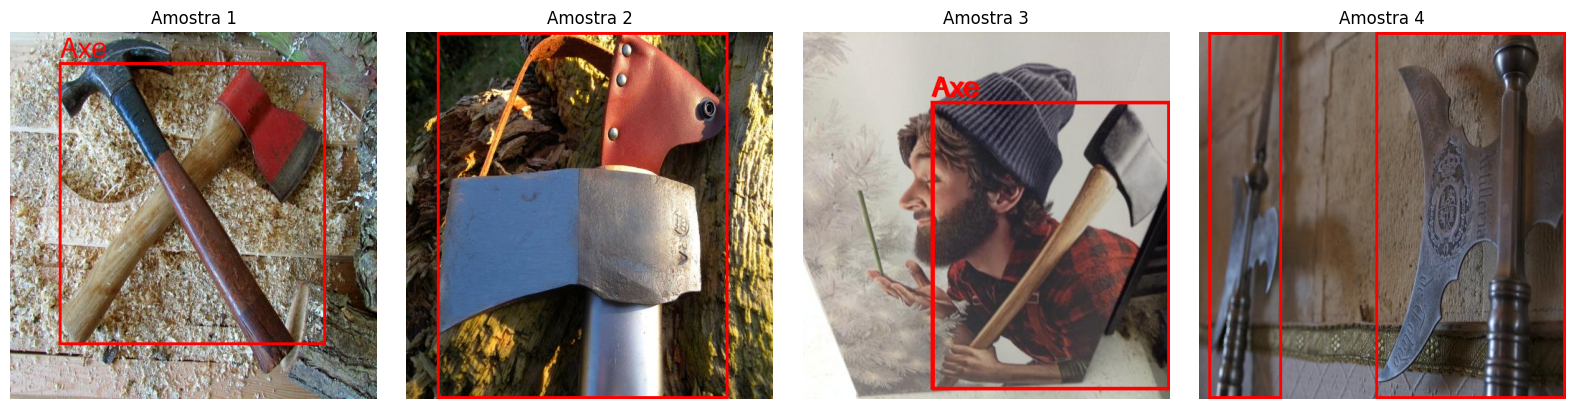

In [3]:
def visualize_sample_images(num_samples=4):
    """Visualiza amostras do dataset com suas anotações"""
    # Usar dataset de validação
    with open('axe_dataset/data.yaml', 'r') as f:
        config = yaml.safe_load(f)

    val_img_dir = "axe_dataset/valid/images"
    val_label_dir = val_img_dir.replace('/images', '/labels')

    class_names = config['names']

    # Selecionar imagens aleatórias
    image_files = [f for f in os.listdir(val_img_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    if len(image_files) < num_samples:
        num_samples = len(image_files)

    sample_images = random.sample(image_files, num_samples)

    plt.figure(figsize=(16, 4))

    for i, img_file in enumerate(sample_images):
        img_path = os.path.join(val_img_dir, img_file)
        label_path = os.path.join(val_label_dir, os.path.splitext(img_file)[0] + '.txt')

        img = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(img)
        w, h = img.size
        font_size = max(int(w * 0.08), 20)

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        x_center, y_center, box_w, box_h = map(float, parts[1:5])

                        x1 = (x_center - box_w / 2) * w
                        y1 = (y_center - box_h / 2) * h
                        x2 = (x_center + box_w / 2) * w
                        y2 = (y_center + box_h / 2) * h

                        draw.rectangle([x1, y1, x2, y2], outline='red', width=4)
                        classe = class_names[class_id] if class_id < len(class_names) else f"Classe {class_id}"
                        draw.text((x1, y1 - font_size - 5), classe, fill='red', font_size=font_size)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Amostra {i + 1}', fontsize=12)

    plt.tight_layout()
    plt.show()

print("🖼️  Visualizando amostras do dataset com anotações reais...")
visualize_sample_images(num_samples=4)

## Treinar o Modelo YOLOv8

**Configurações:**
- Modelo: YOLOv8 Medium (yolov8m)
- Épocas: 50 (ajuste conforme necessário)
- Batch: 16
- Tamanho da imagem: 512x512

In [19]:
# Limpar memória da GPU
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("✓ Memória da GPU limpa")

print("\n" + "=" * 60)
print("INICIANDO TREINAMENTO DO MODELO")
print("=" * 60)

# Carregar o modelo pré-treinado
model = YOLO('yolov8m.pt')

# Treinar com o dataset
results = model.train(
    data='axe_dataset/data.yaml',
    batch=10,
    epochs=100,
    imgsz=512,  # Mesmo tamanho usado no pre-processamento do Roboflow
    patience=20,  # Early stopping
    save=True,
    plots=True,
    device=0 if torch.cuda.is_available() else 'cpu',
    name='axe_detection'
)

print("\n✓ Treinamento concluído!")
print("✓ Modelo salvo em: runs/detect/axe_detection/weights/best.pt")

✓ Memória da GPU limpa

INICIANDO TREINAMENTO DO MODELO
Ultralytics 8.3.235  Python-3.13.5 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=10, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=axe_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=axe_detection4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto,

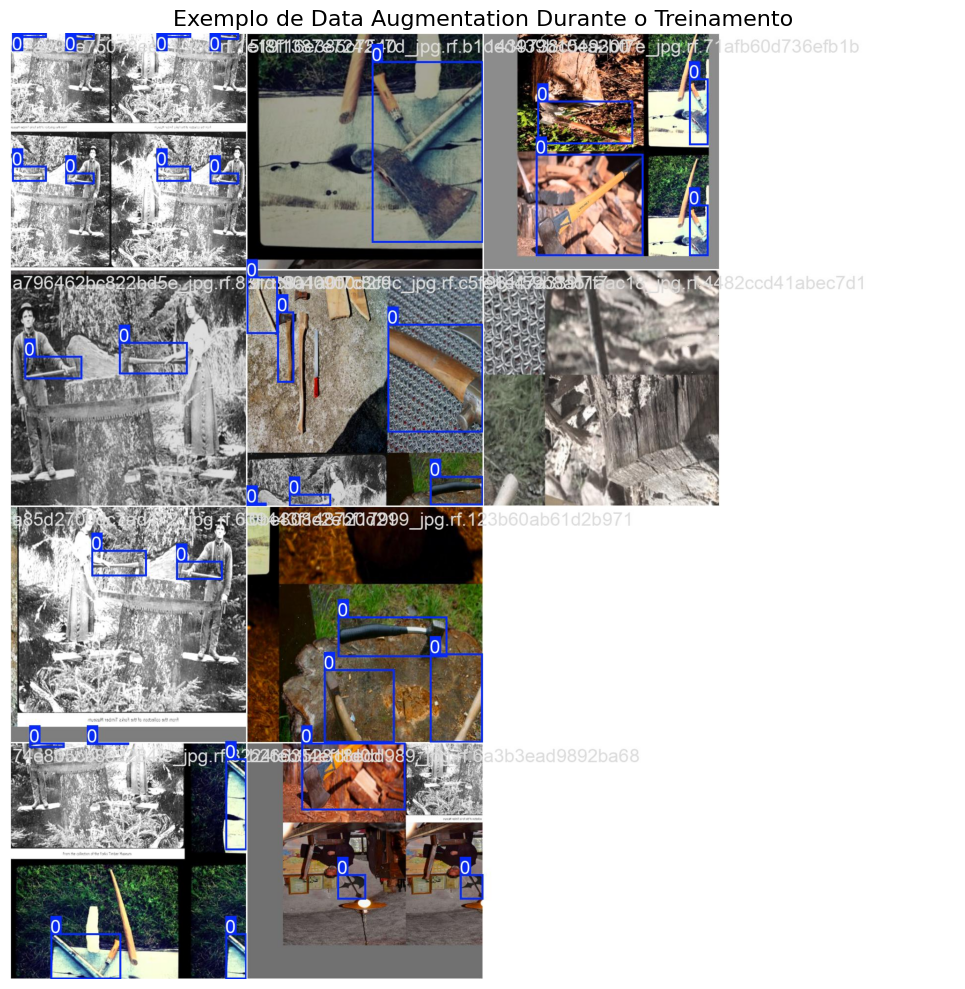

In [ ]:
# Mostrar exemplos de data augmentation
# Primeiro Modelo treinado (Maior precisão/Menor Callback)
aug_img_path = 'runs/detect/axe_detection/train_batch0.jpg'
aug_img_path = 'runs/detect/axe_detection2/train_batch0.jpg'

if os.path.exists(aug_img_path):
    img = Image.open(aug_img_path)

    plt.figure(figsize=(14, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Exemplo de Data Augmentation Durante o Treinamento", fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print(f"⚠️  Imagem não encontrada em {aug_img_path}")

In [ ]:
# Carregar o melhor modelo
# Primeiro Modelo treinado (Maior precisão/Menor Callback)
# best_model = YOLO('runs/detect/axe_detection/weights/best.pt')
best_model = YOLO('runs/detect/axe_detection2/weights/best.pt')

# Validar o modelo
metrics = best_model.val()

# Mostrar métricas
print("\n" + "=" * 60)
print("📊 MÉTRICAS DE DESEMPENHO")
print("=" * 60)
print(f"Precisão (Precision):  {metrics.results_dict.get('metrics/precision(B)', 0):.4f}")
print(f"Revocação (Recall):    {metrics.results_dict.get('metrics/recall(B)', 0):.4f}")
print(f"mAP@0.5:               {metrics.results_dict.get('metrics/mAP50(B)', 0):.4f}")
print(f"mAP@0.5:0.95:          {metrics.results_dict.get('metrics/mAP50-95(B)', 0):.4f}")
print("=" * 60)

print("\n💡 Interpretação:")
print(f"  • Precision: De todas as detecções, {metrics.results_dict.get('metrics/precision(B)', 0)*100:.1f}% estão corretas")
print(f"  • Recall: {metrics.results_dict.get('metrics/recall(B)', 0)*100:.1f}% dos machados foram encontrados")
print(f"  • mAP@0.5: Precisão média com IoU > 50%")

Ultralytics 8.3.235  Python-3.13.5 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access  (ping: 0.10.1 ms, read: 301.0129.4 MB/s, size: 33.9 KB)
val: Scanning C:\Users\lnata\Projects\av3-yolo-training\axe_dataset\valid\labels.cache... 13 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 13/13 22.1Kit/s 0.0s
val: Fast image access  (ping: 0.10.1 ms, read: 301.0129.4 MB/s, size: 33.9 KB)
val: Scanning C:\Users\lnata\Projects\av3-yolo-training\axe_dataset\valid\labels.cache... 13 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 13/13 22.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 2.5s/it 2.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 2.5s/it 2.5

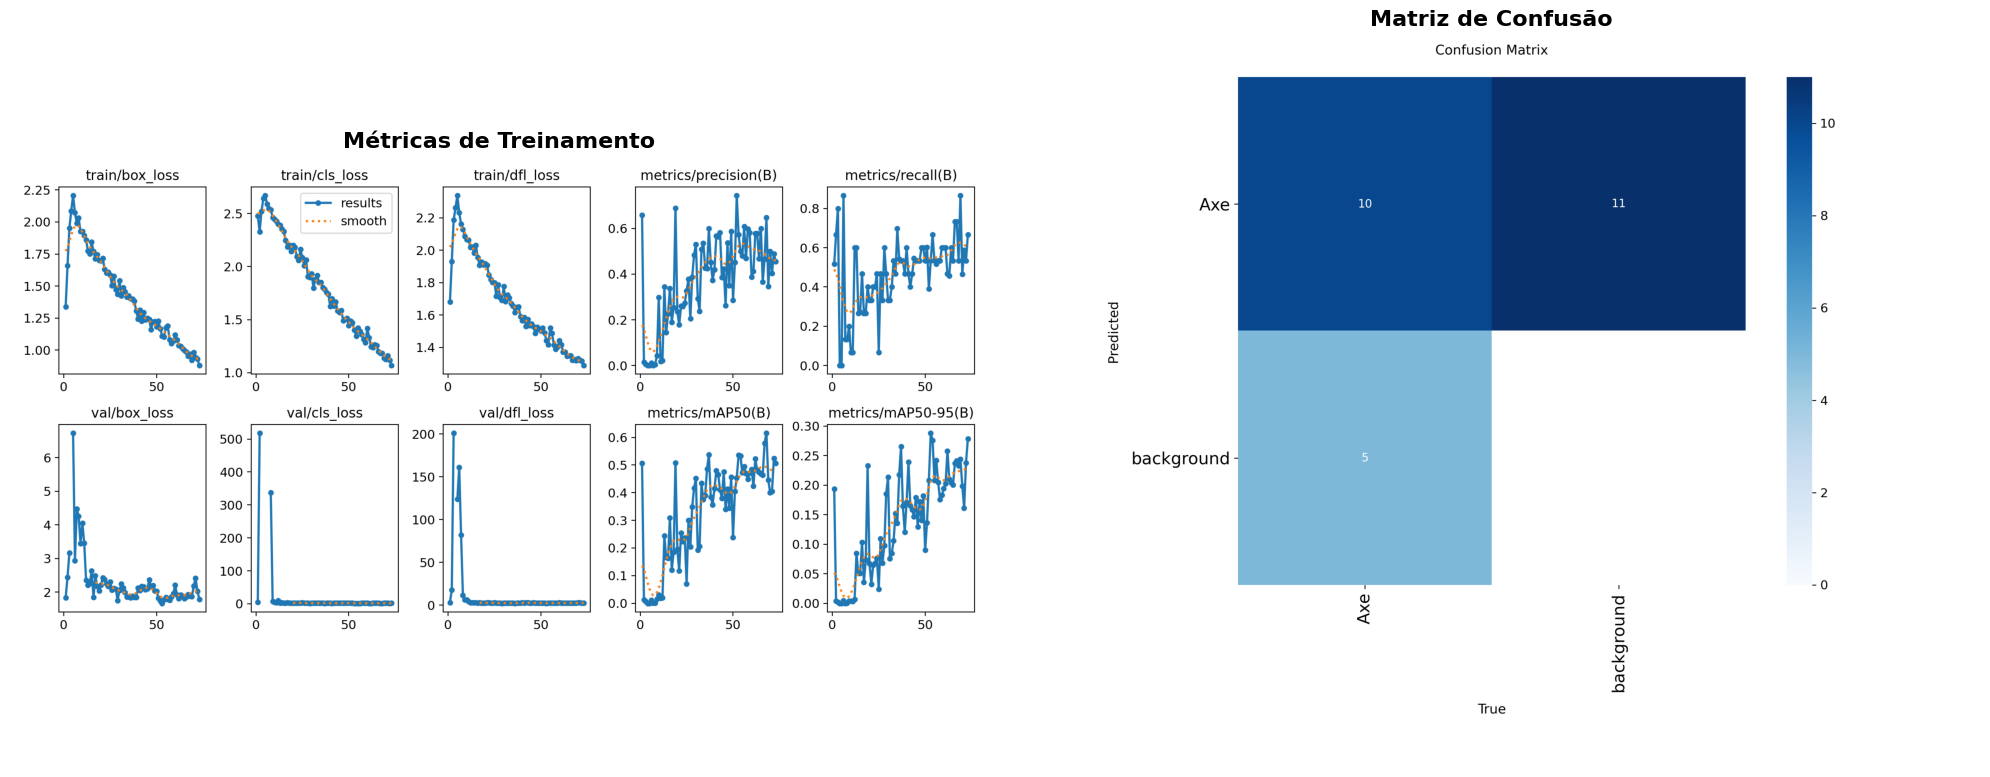

In [ ]:
# Mostrar gráficos de resultados
# Primeiro Modelo treinado (Maior precisão/Menor Callback)
# results_img = 'runs/detect/axe_detection/results.png'
# confusion_img = 'runs/detect/axe_detection/confusion_matrix.png'
results_img = 'runs/detect/axe_detection2/results.png'
confusion_img = 'runs/detect/axe_detection2/confusion_matrix.png'

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

if os.path.exists(results_img):
    img1 = Image.open(results_img)
    axes[0].imshow(img1)
    axes[0].axis('off')
    axes[0].set_title('Métricas de Treinamento', fontsize=16, fontweight='bold')
else:
    axes[0].text(0.5, 0.5, 'Gráfico não encontrado', ha='center', va='center')
    axes[0].axis('off')

if os.path.exists(confusion_img):
    img2 = Image.open(confusion_img)
    axes[1].imshow(img2)
    axes[1].axis('off')
    axes[1].set_title('Matriz de Confusão', fontsize=16, fontweight='bold')
else:
    axes[1].text(0.5, 0.5, 'Gráfico não encontrado', ha='center', va='center')
    axes[1].axis('off')

plt.tight_layout()
plt.show()

🔍 Fazendo predições...


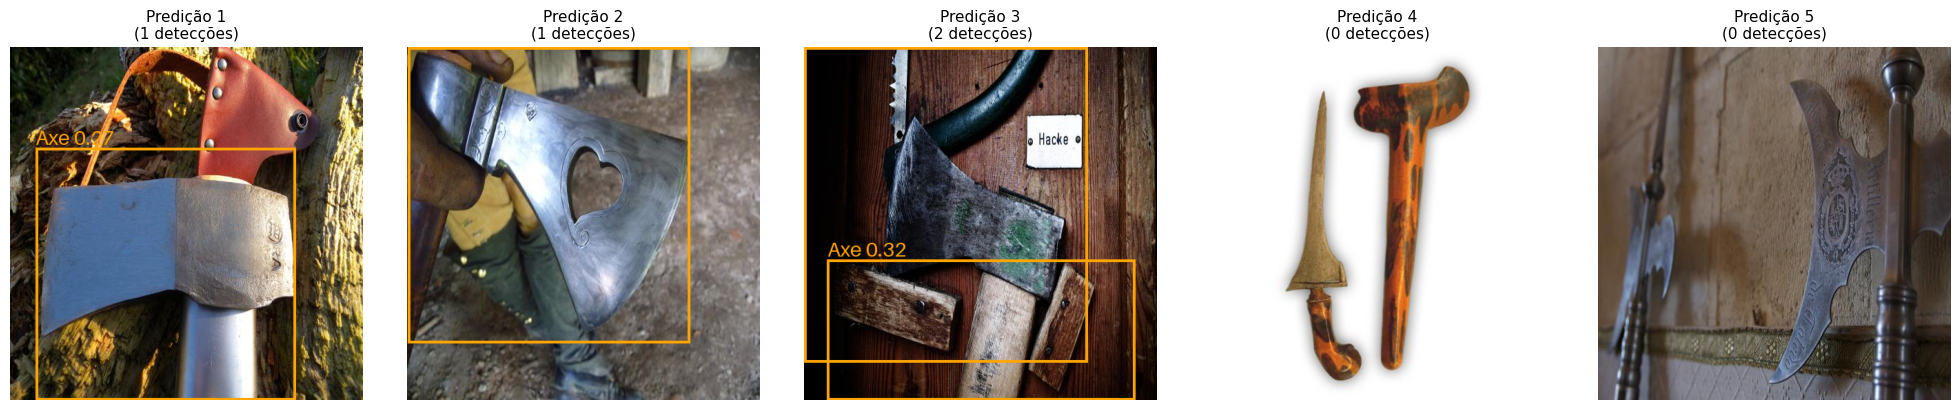


✓ Testadas 5 imagens


In [31]:
# Carregar configuração
with open('axe_dataset/data.yaml', 'r') as f:
    config = yaml.safe_load(f)

val_img_dir = 'axe_dataset/valid/images'

# Selecionar imagens aleatórias do conjunto de validação
test_images = [os.path.join(val_img_dir, f) for f in os.listdir(val_img_dir)
               if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
test_images = random.sample(test_images, min(5, len(test_images)))

# Fazer predições
print("🔍 Fazendo predições...")
preds = [best_model.predict(img_path, verbose=False)[0] for img_path in test_images]

# Plotar resultados
plt.figure(figsize=(20, 4))

for i, (img_path, pred) in enumerate(zip(test_images, preds)):
    img = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    w, h = img.size
    font_size = max(int(w * 0.06), 16)

    boxes = pred.boxes
    num_detections = len(boxes)

    for box, cls, conf in zip(boxes.xyxy, boxes.cls, boxes.conf):
        x1, y1, x2, y2 = box.tolist()
        class_id = int(cls.item())
        class_name = best_model.names[class_id]
        confidence = conf.item()

        # Cor baseada na confiança
        color = "green" if confidence > 0.5 else "orange"

        draw.rectangle([x1, y1, x2, y2], outline=color, width=4)
        draw.text((x1, y1 - font_size - 5), f"{class_name} {confidence:.2f}",
                 fill=color, font_size=font_size)

    plt.subplot(1, len(test_images), i + 1)
    plt.imshow(img)
    plt.title(f"Predição {i + 1}\n({num_detections} detecções)", fontsize=11)
    plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ Testadas {len(test_images)} imagens")


🔍 Testando em: R.jpg


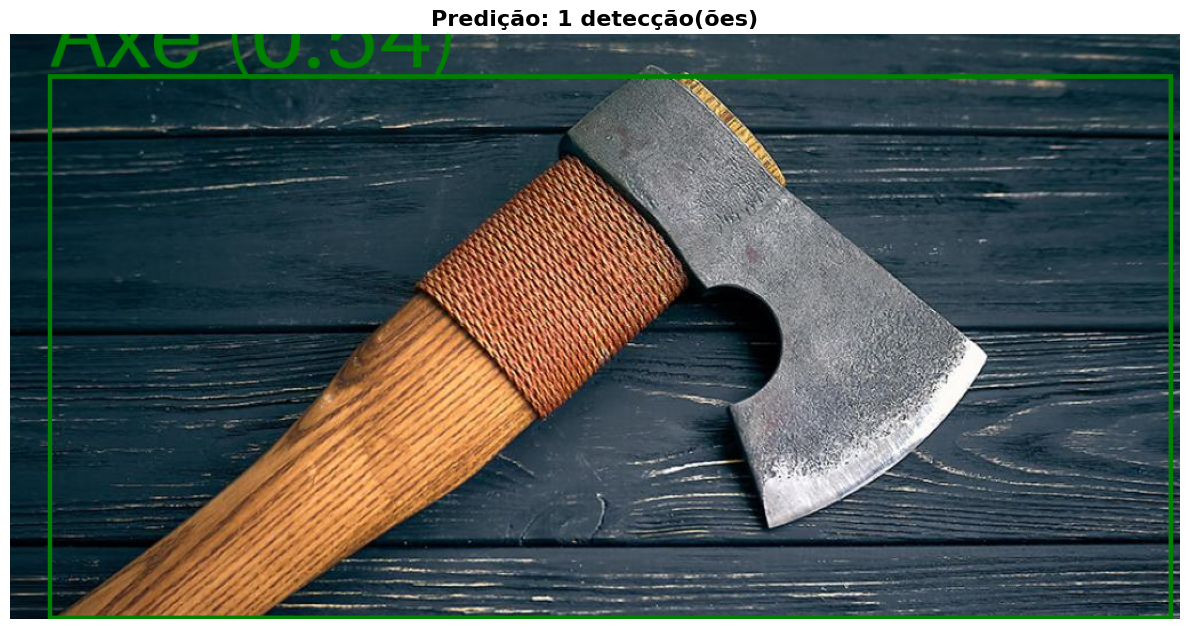


✓ Detectados 1 objeto(s)

📋 Detalhes das detecções:
  1. Axe - Confiança: 53.75%
     BBox: [33.5, 36.7, 1017.6, 512.0]

💡 Para testar uma imagem, use:
   test_custom_image('caminho/para/sua/imagem.jpg')


In [ ]:
# Configurar matplotlib para notebooks
%matplotlib inline

# Testar com uma imagem local
def test_custom_image(image_path):
    """Testa o modelo com uma imagem customizada"""
    if not os.path.exists(image_path):
        print(f"❌ Imagem não encontrada: {image_path}")
        return
    
    print(f"\n🔍 Testando em: {os.path.basename(image_path)}")
    
    # Fazer predição
    results = best_model.predict(image_path, conf=0.25, verbose=False)
    
    # Carregar imagem original
    img_original = Image.open(image_path).convert("RGB")
    
    # Criar cópia para desenhar as predições
    img_pred = img_original.copy()
    draw = ImageDraw.Draw(img_pred)
    w, h = img_pred.size
    font_size = max(int(w * 0.08), 20)
    
    total_detections = 0
    detections_info = []
    
    for result in results:
        boxes = result.boxes
        total_detections = len(boxes)
        
        for box, cls, conf in zip(boxes.xyxy, boxes.cls, boxes.conf):
            x1, y1, x2, y2 = box.tolist()
            class_name = best_model.names[int(cls.item())]
            confidence = conf.item()
            
            detections_info.append({
                'class': class_name,
                'confidence': confidence,
                'bbox': (x1, y1, x2, y2)
            })
            
            draw.rectangle([x1, y1, x2, y2], outline="green", width=4)
            draw.text((x1, y1 - font_size - 5), f"{class_name} ({confidence:.2f})",
                     fill="green", font_size=font_size)
    
    # Mostrar apenas a predição
    plt.figure(figsize=(12, 8))
    plt.imshow(img_pred)
    plt.axis('off')
    plt.title(f'Predição: {total_detections} detecção(ões)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Mostrar detalhes das detecções
    print(f"\n✓ Detectados {total_detections} objeto(s)")
    if detections_info:
        print("\n📋 Detalhes das detecções:")
        for i, det in enumerate(detections_info, 1):
            print(f"  {i}. {det['class']} - Confiança: {det['confidence']:.2%}")
            print(f"     BBox: [{det['bbox'][0]:.1f}, {det['bbox'][1]:.1f}, {det['bbox'][2]:.1f}, {det['bbox'][3]:.1f}]")

# Exemplo de uso - substitua pelo caminho da sua imagem
test_custom_image("teste_machado.jpg")
